In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2, os, glob, re, torch, random, time
import numpy as np
import imgaug
from imgaug import augmenters
import torch

In [2]:
img = torch.ones(300, 300, 3).long() * 255
prior = torch.tensor([[10, 10, 220, 280]]).float()
reg = torch.tensor([[35, 45, 275, 225]]).float()

In [3]:
def center_conv_point_vanilla(bboxes, kernel_size=3, c_min=0, c_max=1):
    prior_centers = []
    for bbox in bboxes:
        c_x = bbox[2:] - bbox[:2]
        x1, y1, x2, y2 = bbox.clamp(min=c_min, max=c_max)
        # the gradient was not kept
        step_x = float((x2 - x1) / kernel_size)
        start_x = float(x1 + step_x / 2)
        end_x = float(x2)
        step_y = float((y2 - y1) / kernel_size)
        start_y = float(y1 + step_y / 2)
        end_y = float(y2)
        prior_center = torch.meshgrid([torch.arange(start_x, end_x, step_x),
                                       torch.arange(start_y, end_y, step_y)])
        prior_center = torch.stack(prior_center, dim=-1).contiguous().view(-1)
        prior_centers.append(prior_center)
    return torch.stack(prior_centers, dim=0)   

def center_conv_point_parallel(bboxes, kernel_size=3, c_min=0, c_max=1):
    bboxes.clamp_(min=c_min, max=c_max)
    base = torch.cat([bboxes[:, :2]] * (kernel_size ** 2), dim=1)
    if bboxes.is_cuda:
        multiplier = torch.tensor([(2 * i + 1) / kernel_size / 2 for i in range(kernel_size)]).cuda()
    else:
        multiplier = torch.tensor([(2 * i + 1) / kernel_size / 2 for i in range(kernel_size)])
    multiplier = torch.stack(torch.meshgrid([multiplier, multiplier]), dim=-1).contiguous().view(-1)
    multiplier = multiplier.unsqueeze(0).repeat(bboxes.size(0), 1)
    center = torch.stack([bboxes[:, 2] - bboxes[:, 0], bboxes[:, 3] - bboxes[:, 1]], dim=-1)
    center = torch.cat([center] * (kernel_size ** 2), dim=1)
    return base + center * multiplier

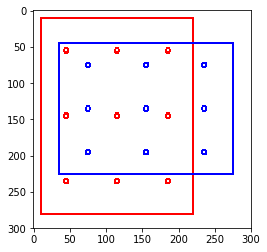

In [4]:
def plot_box(image, prior_box, reg_box):
    image = image.data.numpy().astype("uint8").copy()
    
    # get prior box and its inter conv points
    prior_conv_center = center_conv_point_parallel(prior_box, c_max=300)
    # Draw conv center
    for coord in prior_conv_center.view(-1, 2):
        cv2.circle(image, (int(coord[0]), int(coord[1])), 3, (255, 0, 0), 2)
    prior_box = prior_box.long().data.numpy()
    
    # get regressed box and its regress conv points
    reg_conv_center = center_conv_point_parallel(reg_box, c_max=300)
    for coord in reg_conv_center.view(-1, 2):
        cv2.circle(image, (int(coord[0]), int(coord[1])), 3, (0, 0, 255), 2)
    reg_box = reg_box.long().data.numpy()
    
    # Draw the box out
    x1, y1, x2, y2 = prior_box[0]
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    x1, y1, x2, y2 = reg_box[0]
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    plt.imshow(image)
    return prior_conv_center, reg_conv_center
prior_conv_center, reg_conv_center = plot_box(img, prior, reg)
deformation_map = reg_conv_center - prior_conv_center

In [5]:
kernel_size = 3
n_sample = 1024
base = torch.randn(n_sample, 2).clamp(min=0, max=0.5)
bboxes = torch.cat([base, base + torch.randn(n_sample, 2).clamp(min=0.1, max=0.5)], dim=1).contiguous().cuda()
print("Ground truth:")
print(center_conv_point_vanilla(bboxes))
print("")
print("Parallel:")
print(center_conv_point_parallel(bboxes))

torch.sum(center_conv_point_parallel(bboxes) - center_conv_point_vanilla(bboxes).cuda())

Ground truth:
tensor([[0.5330, 0.0167, 0.5330,  ..., 0.0500, 0.6648, 0.0833],
        [0.4636, 0.0717, 0.4636,  ..., 0.2152, 0.7969, 0.3587],
        [0.5833, 0.4079, 0.5833,  ..., 0.5252, 0.9167, 0.6426],
        ...,
        [0.0224, 0.3457, 0.0224,  ..., 0.5123, 0.1119, 0.6790],
        [0.0167, 0.0167, 0.0167,  ..., 0.0500, 0.0833, 0.0833],
        [0.0657, 0.0833, 0.0657,  ..., 0.2500, 0.3287, 0.4167]])

Parallel:
tensor([[0.5330, 0.0167, 0.5330,  ..., 0.0500, 0.6648, 0.0833],
        [0.4636, 0.0717, 0.4636,  ..., 0.2152, 0.7969, 0.3587],
        [0.5833, 0.4079, 0.5833,  ..., 0.5252, 0.9167, 0.6426],
        ...,
        [0.0224, 0.3457, 0.0224,  ..., 0.5123, 0.1119, 0.6790],
        [0.0167, 0.0167, 0.0167,  ..., 0.0500, 0.0833, 0.0833],
        [0.0657, 0.0833, 0.0657,  ..., 0.2500, 0.3287, 0.4167]],
       device='cuda:0')


tensor(-3.7998e-06, device='cuda:0')

In [6]:
p = torch.tensor([[0.0133, 0.0133, 0.1000, 0.1000]])
center_conv_point_parallel(p)

tensor([[0.0278, 0.0278, 0.0278, 0.0566, 0.0278, 0.0856, 0.0566, 0.0278, 0.0566,
         0.0566, 0.0566, 0.0856, 0.0856, 0.0278, 0.0856, 0.0566, 0.0856, 0.0856]])

In [12]:
best_prior_idx = torch.tensor([3, 3, 0, 1, 7, 7])
best_truth_idx = torch.tensor([2, 3, 1, 0, 3, 4, 0, 5])

In [11]:
best_truth_idx[best_prior_idx] = torch.arange(best_prior_idx.size(0))
best_truth_idx

tensor([2, 3, 1, 1, 3, 4, 0, 5])

In [13]:
for j in range(best_prior_idx.size(0)):
    best_truth_idx[best_prior_idx[j]] = j
best_truth_idx

tensor([2, 3, 1, 1, 3, 4, 0, 5])